# Regression Part 2

The first series of notebooks walked you through a regression, from swimming, to feature generation, to final analysis.  In this notebook, we will take a step back on the Newark real estate dataset and first look at SQFT the best predictor of the ZESTIMATE. Let's load up the data and generate our features:

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

houses = pd.read_csv('OldNewark.csv')
df2 = houses.copy()

df2['FACEWEST'] = df2['STREETNO'] % 2
df2['ORCHARD'] = 0
df2.loc[df2['STREET'] == 'Orchard', 'ORCHARD'] = 1
df2['AGE'] = 2019 - df2['YRBUILT']

lotsqft = df2['LOTSIZE'] * 43560 # convert pct to sqft
df2['COVERAGE'] = (df2['SQFT']/2) / lotsqft # assume two stories. Half of house is on the ground
df2['SALESAGE'] = 2019 - df2['YRSOLD']

## Generate the regression

In [14]:
# split data into X and Y dataframes
X = df2[['SQFT']].copy()
Y = df2['ZESTIMATE'].copy()

In [15]:
df2.columns

Index(['ID', 'STREETNO', 'STREET', 'ZESTIMATE', 'SQFT', 'BEDR', 'BATHR',
       'YRBUILT', 'LOTSIZE', 'SOLDFOR', 'YRSOLD', 'FACEWEST', 'ORCHARD', 'AGE',
       'COVERAGE', 'SALESAGE'],
      dtype='object')

In [16]:
# Run regression using statsmodels
import statsmodels.api as sm

X = sm.add_constant(X) # required if constant expected
est = sm.OLS(Y,X).fit() # fit model
predictions = est.predict() # get predicted values
print(est.summary())
print("\nAverage error: {:.2f}.".format(math.sqrt(est.mse_resid)))

                            OLS Regression Results                            
Dep. Variable:              ZESTIMATE   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     190.1
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           3.28e-29
Time:                        14:49:59   Log-Likelihood:                -2014.9
No. Observations:                 166   AIC:                             4034.
Df Residuals:                     164   BIC:                             4040.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.519e+05   1.18e+04     12.854      0.0

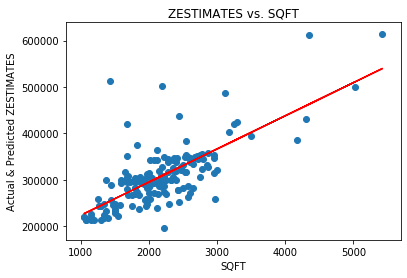

In [17]:
plt.ylabel('Actual & Predicted ZESTIMATES')
plt.xlabel('SQFT')
plt.title('ZESTIMATES vs. SQFT')
plt.plot(X['SQFT'], predictions, c='r')
plt.scatter(X['SQFT'], Y)
plt.show()

### Things to note
The variance above the line seems to be greater than below the line.  This may be problematic, since regression assumes that the variation is consistent across all values of the independent variables.  This assumption is called homoscedascity.

In [18]:
df2['HIGHPRICED'] = df2.ZESTIMATE > 450000
df2 = df2.dropna()

In [19]:
df2.columns

Index(['ID', 'STREETNO', 'STREET', 'ZESTIMATE', 'SQFT', 'BEDR', 'BATHR',
       'YRBUILT', 'LOTSIZE', 'SOLDFOR', 'YRSOLD', 'FACEWEST', 'ORCHARD', 'AGE',
       'COVERAGE', 'SALESAGE', 'HIGHPRICED'],
      dtype='object')

In [20]:
temp = df2[['YRSOLD','HIGHPRICED','SQFT']].copy()
temp.groupby('HIGHPRICED').describe().transpose()

HIGHPRICED          False        True 
YRSOLD count   116.000000     6.000000
       mean   2004.413793  2015.333333
       std      12.326055     5.887841
       min    1971.000000  2004.000000
       25%    1997.750000  2014.750000
       50%    2006.000000  2018.000000
       75%    2015.250000  2019.000000
       max    2019.000000  2019.000000
SQFT   count   116.000000     6.000000
       mean   2122.137931  3592.000000
       std     559.189956  1602.929818
       min    1050.000000  1425.000000
       25%    1750.000000  2431.250000
       50%    2150.000000  3737.500000
       75%    2500.000000  4856.250000
       max    4310.000000  5427.000000

The above analysis suggests that houses that are above \\$450000 were sold on average ten years after the other houses.  They are also much bigger, on average.  This suggests that more recent houses are higher priced higher.

In [21]:
# split data into X and Y dataframes
X = df2[['SQFT','YRSOLD']].copy()
Y = df2['ZESTIMATE'].copy()

In [22]:
# Run regression using statsmodels
import statsmodels.api as sm

X = sm.add_constant(X) # required if constant expected
est = sm.OLS(Y,X).fit() # fit model
predictions = est.predict() # get predicted values
print(est.summary())
print("\nAverage error: {:.2f}.".format(math.sqrt(est.mse_resid)))

                            OLS Regression Results                            
Dep. Variable:              ZESTIMATE   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     68.47
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           1.63e-20
Time:                        14:49:59   Log-Likelihood:                -1491.4
No. Observations:                 122   AIC:                             2989.
Df Residuals:                     119   BIC:                             2997.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.024e+06   7.42e+05     -1.380      0.1

Including YRSOLD didnt have an appreciable effect on our model.

### The Outlier Effect
We have demonstrated that the three houses that are greater than 4000 sqft can be considered outliers.  For example:

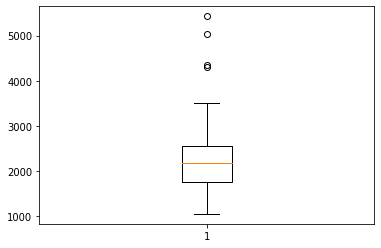

In [23]:
plt.boxplot(df2.SQFT)
plt.show()

Let's run the above regression again, but this time without the outliers

In [24]:
df3 = df2[df2.SQFT < 4000].copy()

In [25]:
# split data into X and Y dataframes
X = df3[['SQFT','YRSOLD']].copy()
Y = df3['ZESTIMATE'].copy()

In [26]:
# Run regression using statsmodels
import statsmodels.api as sm

X = sm.add_constant(X) # required if constant expected
est = sm.OLS(Y,X).fit() # fit model
predictions = est.predict() # get predicted values
print(est.summary())
print("\nAverage error: {:.2f}.".format(math.sqrt(est.mse_resid)))

                            OLS Regression Results                            
Dep. Variable:              ZESTIMATE   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     27.47
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           1.77e-10
Time:                        14:49:59   Log-Likelihood:                -1438.7
No. Observations:                 118   AIC:                             2883.
Df Residuals:                     115   BIC:                             2892.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.077e+05   7.35e+05     -0.827      0.4

YRSOLD is not a significant predictor.  Examine the R<sup>2</sup> and the average error levels.  Note that the R<sup>2</sup> dropped! This indicates that although we have outliers, they arent affecting our model much.  It seems that although they are much larger, the ZESTIMATE (because it is so heavily based on SQFT) is consistent with the larger size.  The question will be, however, what is the effect on the selling price?

### Complete Your Own Analysis of Newark Real Estate
Using the above as a guide, complete a regression analysis using SOLDFOR, which is the actual selling price of a house.  Your goal is to create a model that predicts and explains the selling price of a house.  You may NOT use ZESTIMATE, STREETNO, or ID as a predictor! Some suggestions:
* Dont chase higher R<sup>2</sup> values.  Dont forget to watch the error levels **as well as** R<sup>2</sup>
* Examine the effect on adjusted R<sup>2</sup> when adding a variable.  If the adjusted R<sup>2</sup> drops, it suggests the new variable may not be adding valuable information.
* Examine the regression coefficients and their relative significance.  Your final model should include only significant predictors.

In [28]:
# split data into X and Y dataframes
X = df2[['SQFT']].copy()
Y = df2['SOLDFOR'].copy()

In [29]:
# Run regression using statsmodels
import statsmodels.api as sm

X = sm.add_constant(X) # required if constant expected
est = sm.OLS(Y,X).fit() # fit model
predictions = est.predict() # get predicted values
print(est.summary())
print("\nAverage error: {:.2f}.".format(math.sqrt(est.mse_resid)))

                            OLS Regression Results                            
Dep. Variable:                SOLDFOR   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     10.28
Date:                Tue, 14 Jul 2020   Prob (F-statistic):            0.00173
Time:                        14:50:00   Log-Likelihood:                -1603.0
No. Observations:                 122   AIC:                             3210.
Df Residuals:                     120   BIC:                             3216.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.488e+05   3.66e+04      4.069      0.0

In [30]:
# split data into X and Y dataframes
X = df2[['SQFT','YRSOLD','ORCHARD','YRBUILT']].copy()
Y = df2['SOLDFOR'].copy()

In [31]:
# Run regression using statsmodels
import statsmodels.api as sm

X = sm.add_constant(X) # required if constant expected
est = sm.OLS(Y,X).fit() # fit model
predictions = est.predict() # get predicted values
print(est.summary())
print("\nAverage error: {:.2f}.".format(math.sqrt(est.mse_resid)))

                            OLS Regression Results                            
Dep. Variable:                SOLDFOR   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     64.50
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           1.06e-28
Time:                        14:50:00   Log-Likelihood:                -1536.9
No. Observations:                 122   AIC:                             3084.
Df Residuals:                     117   BIC:                             3098.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.245e+06   1.57e+06     -5.240      0.0

In [32]:
X = df2[['SQFT','YRSOLD','ORCHARD','YRBUILT','SOLDFOR']].copy()
corr = X.corr()
corr.style.background_gradient()

,SQFT,YRSOLD,ORCHARD,YRBUILT,SOLDFOR
SQFT,1.000000,-0.069698,0.309589,0.104166,0.280854
YRSOLD,-0.069698,1.000000,0.166118,-0.154098,0.635992
ORCHARD,0.309589,0.166118,1.000000,-0.436743,0.567511
YRBUILT,0.104166,-0.154098,-0.436743,1.000000,-0.399611
SOLDFOR,0.280854,0.635992,0.567511,-0.399611,1.000000


In [33]:
# split data into X and Y dataframes
X = df2[['SQFT']].copy()
Y = df2['ZESTIMATE'].copy()

In [34]:
# Run regression using statsmodels
import statsmodels.api as sm

X = sm.add_constant(X) # required if constant expected
est = sm.OLS(Y,X).fit() # fit model
predictions = est.predict() # get predicted values
print(est.summary())
print("\nAverage error: {:.2f}.".format(math.sqrt(est.mse_resid)))

                            OLS Regression Results                            
Dep. Variable:              ZESTIMATE   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     132.8
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           3.83e-21
Time:                        14:50:00   Log-Likelihood:                -1492.7
No. Observations:                 122   AIC:                             2989.
Df Residuals:                     120   BIC:                             2995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.48e+05   1.48e+04      9.992      0.0

In [35]:
# split data into X and Y dataframes
X = df2[['SQFT','ORCHARD']].copy()
Y = df2['ZESTIMATE'].copy()

In [36]:
# Run regression using statsmodels
import statsmodels.api as sm

X = sm.add_constant(X) # required if constant expected
est = sm.OLS(Y,X).fit() # fit model
predictions = est.predict() # get predicted values
print(est.summary())
print("\nAverage error: {:.2f}.".format(math.sqrt(est.mse_resid)))

                            OLS Regression Results                            
Dep. Variable:              ZESTIMATE   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     106.4
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           3.22e-27
Time:                        14:50:00   Log-Likelihood:                -1475.6
No. Observations:                 122   AIC:                             2957.
Df Residuals:                     119   BIC:                             2966.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.639e+05   1.32e+04     12.435      0.0

In [37]:
# split data into X and Y dataframes
X = df2[['SQFT','ORCHARD']].copy()
X['ORCHXSQFT'] = X.ORCHARD * X.SQFT
Y = df2['ZESTIMATE'].copy()

In [38]:
# Run regression using statsmodels
import statsmodels.api as sm

X = sm.add_constant(X) # required if constant expected
est = sm.OLS(Y,X).fit() # fit model
predictions = est.predict() # get predicted values
print(est.summary())
print("\nAverage error: {:.2f}.".format(math.sqrt(est.mse_resid)))

                            OLS Regression Results                            
Dep. Variable:              ZESTIMATE   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     70.39
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           3.62e-26
Time:                        14:50:00   Log-Likelihood:                -1475.5
No. Observations:                 122   AIC:                             2959.
Df Residuals:                     118   BIC:                             2970.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.66e+05    1.5e+04     11.061      0.0